# Goals for this code
- View tiff file in napari for nice visualisation
- Save each frame from tiff-file in a folder and appropraitely name them
- Iterate through the images/files in the folder and crop each of them, (looks like based on what you gave me Jonas that Fourier analysis may be the best approach?)
- Then would be nice to align these traps as I've (at least tentatively) managed to do
- But also save each cropped trap corresponding to a number in separate folders so all first traps in the file in one folder, etc. as we talked about for later
### With the fourier analysis working well, while my code works decent i think that your approach may be easier, since producing the overlay may not be needed at all? 

# View tiff file in napari
#### take tiff-file and view it in napari

In [1]:
import napari 
from skimage import io

original_tiff_image_series = "C:/Users/micha/Desktop/Master_Project/TIFF_FILES/tiff_file_converted_2.tiff"
original_image_series = io.imread(original_tiff_image_series)

viewer = napari.view_image(original_image_series, colormap='gray', name ='Original Image Series')

# Save all tiff-file frames in a folder as png
#### Note: the images feel a bit bright? not sure if that's an issue or not (see cell below)

In [85]:
import imageio
import numpy as np
from PIL import Image
import os

# Open the TIFF image file
file_path = "C:/Users/micha/Desktop/Master_Project/TIFF_FILES/tiff_file_converted.tiff"
output_folder = 'C:/Users/micha/Desktop/Mastera_Project/Original_tiff_frames'
os.makedirs(output_folder, exist_ok=True)

# Read TIFF file using imageio
tiff_frames = imageio.volread(file_path)

# Total number of frames in the TIFF file
num_frames = tiff_frames.shape[0]
print(f'Number of total frames: {num_frames}')

for frame_to_display in range(num_frames):
    # Extract Specific Frame:
    tiff_data = tiff_frames[frame_to_display]

    # Ensure the image is in uint8 format
    tiff_data = (tiff_data / np.max(tiff_data) * 255).astype(np.uint8)

    # Convert single-channel image to 3-channel image
    tiff_data_color = np.stack([tiff_data] * 3, axis=-1)

    # Flip the image 90 degrees to the right
    flipped_tiff_data = np.rot90(tiff_data_color)

    # Save the flipped TIFF frame as PNG using PIL
    output_path = os.path.join(output_folder, f'original_frame_{frame_to_display + 1}.png')
    Image.fromarray(flipped_tiff_data).save(output_path)
    print(f'Saved original frame {frame_to_display + 1} as PNG')



Number of total frames: 392



KeyboardInterrupt



#### example image from last cell:

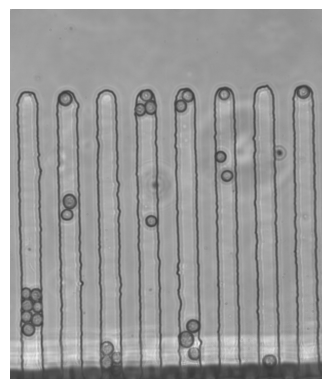

In [79]:
# Path to the PNG image
image_path = r"C:\Users\micha\Desktop\Master_Project\Original_tiff_frames\original_frame_1.png"

# Read the image using imread
image = imread(image_path)

# Display the image
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

# Overlay for single frame
#### note: cant reproduce this overlay for all tiff images in the series and leave the the cells and traps "untouched" (as i tried to do in the cell below)

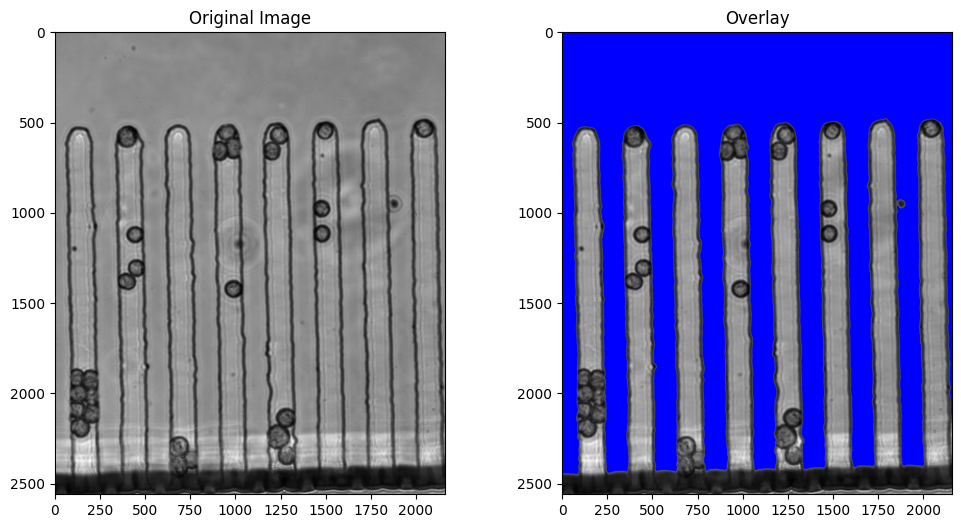

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from scipy import ndimage

# Read the image in grayscale
image_path = 'C:/Users/micha/Desktop/Master_Project/original_frame_392.png'
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Step 1: Apply Otsu's Thresholding
_, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Step 2: Perform Morphological Operations (optional)
kernel = np.ones((5, 5), np.uint8)
binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)  # Closing operation

# Step 3: Apply Distance Transform and Threshold
distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)
_, sure_fg = cv2.threshold(distance_transform, 0.7 * distance_transform.max(), 255, 0)
sure_fg = np.uint8(sure_fg)

# Step 4: Finding Sure Background
sure_bg = cv2.dilate(binary_image, kernel, iterations=3)

# Step 5: Finding Unknown Region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Step 6: Label Markers for Watershed Segmentation
_, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Step 7: Apply Watershed Algorithm
labels = watershed(-distance_transform, markers, mask=binary_image)

# Overlay the segmentation on the original image
overlay = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
overlay[labels > 1] = [0, 0, 255]  # Color the segmented regions in red 
#mask 
# Save the overlay image as a PNG
cv2.imwrite('C:/Users/micha/Desktop/Master_Project/overlay_image_392.png', overlay)

# Visualize the original image and the overlay
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title('Overlay')

plt.show()


# Overlay (mask) for tiff-file (series)
### take tiff-file, produce overlay (segmenting) & save to a folder
#### note: can't get it to work nicely, would like all images to be as the one displayed in cell below (may not be relevant with the fourier transfrom?)

In [ ]:
import cv2
import numpy as np
import os
import tifffile
from skimage.segmentation import watershed

def watershed_overlay(image):
    # Convert the image to uint8
    image = (image * 255).astype(np.uint8)

    # Ensure the image has three channels
    if image.ndim == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Apply Otsu's Thresholding
    _, binary_image = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Ensure binary_image is of type CV_8UC1
    binary_image = binary_image.astype(np.uint8)

    # Step 3: Perform Morphological Operations (optional)
    kernel = np.ones((5, 5), np.uint8)
    binary_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)  # Closing operation

    # Step 4: Apply Distance Transform and Threshold
    distance_transform = cv2.distanceTransform(binary_image, cv2.DIST_L2, 3)
    _, sure_fg = cv2.threshold(distance_transform, 0.7 * distance_transform.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    # Step 5: Finding Sure Background
    sure_bg = cv2.dilate(binary_image, kernel, iterations=3)

    # Step 6: Finding Unknown Region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg, sure_fg)

    # Step 7: Label Markers for Watershed Segmentation
    _, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    # Step 8: Apply Watershed Algorithm
    labels = watershed(-distance_transform, markers, mask=binary_image)

    # Overlay the segmentation on the original image
    overlay = image.copy()
    overlay[labels > 1] = [0, 0, 255]  # Color the segmented regions in red

    return overlay

# Directory for saving flipped overlay images
output_folder = 'C:/Users/micha/Desktop/Master_Project/Flipped_overlay_images'
os.makedirs(output_folder, exist_ok=True)

# Open the TIFF image file and convert to grayscale
file_path = "C:/Users/micha/Desktop/Master_Project/tiff_file_converted.tiff"
with tifffile.TiffFile(file_path) as tif:
    num_frames = len(tif.pages)
    print(f'Number of total frames: {num_frames}')

    for frame_to_display in range(num_frames):
        # Extract Specific Frame
        tiff_data = tif.asarray(key=frame_to_display)

        # Perform Watershed Segmentation and get the overlay
        overlay = watershed_overlay(tiff_data)

        # Flip the overlay image 90 degrees to the right
        flipped_overlay = cv2.rotate(overlay, cv2.ROTATE_90_CLOCKWISE)

        # Save the flipped overlay image
        flipped_output_path = os.path.join(output_folder, f'flipped_overlay_image_{frame_to_display + 1}.png')
        cv2.imwrite(flipped_output_path, flipped_overlay)

        print(f'Processed frame {frame_to_display + 1}/{num_frames}')

print(f'Flipped overlay images saved to: {output_folder}')



# Crop traps
#### project intesity values along x-axis, iterate through projection and crop traps based on threshold (with a +- margin)
#### Also save coordinates for later use

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
import napari

# Step 0: Read the image using an appropriate method
image_path_overlay= 'C:/Users/micha/Desktop/Master_Project/overlay_image_392_flipped.png'
image_overlay = imread(image_path_overlay)

# Convert the image to grayscale if it has three color channels
if image_thing_3.ndim == 3:
    image_thing_3 = np.mean(image_thing_3, axis=-1)  # take mean values across X-axis

# Check the shape of the image
print("Image Shape:", image_thing_3.shape)

# Step 1: Set a threshold for intensity values
threshold = 840  # Adjust the threshold based on your data
margin = 50  # Adjust the margin based on your requirement

# Step 2: Iterate through the x-axis and identify traps based on intensity values
# parameters for for-loop and cropping
traps = []
trap_started = False
current_trap = None
trap_coordinates = []

for x in range(image_thing_3.shape[1]):  # iterate over each column in the x-axis
    if image_thing_3[:, x].sum() > threshold:  # if intensity value for each column is over intensity-threshold
        if not trap_started:
            trap_started = True  # start trap
            start_x = x - margin  # start value for cropping
            current_trap = image_thing_3[:, start_x:x + 1]
        else:
            current_trap = np.hstack([current_trap, image_thing_3[:, x:x + 1]])
    else:
        if trap_started:
            end_x = x + margin
            traps.append(current_trap)
            trap_coordinates.append((start_x, end_x))
            trap_started = False  # Reset trap_started

# Ensure all arrays in traps have the same length along the second axis
max_length = max(trap.shape[1] for trap in traps)

# Adjust the traps to have the same length
traps = [np.pad(trap, ((0, 0), (0, max_length - trap.shape[1])), mode='constant') for trap in traps]

# Save trap coordinates for later use
trap_coordinates = np.array(trap_coordinates)
np.save('trap_coordinates.npy', trap_coordinates)

# Create a Napari viewer for cropped traps
viewer = napari.Viewer()

# Create a single layer with all the traps stacked on top of each other
stacked_traps = np.vstack(traps)
viewer.add_image(stacked_traps, colormap='gray', name='Stacked Traps')

# Show the Napari viewer
napari.gui_qt()


Image Shape: (2560, 2160)


C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 188) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 188) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


# Trap cropping for multiple images
### uses saved coordinates from earlier image to crop traps for files in folder (in order) and align in napari

In [77]:
import os
import numpy as np
from PIL import Image
import re
import napari

# Folder containing the images
folder_path = r'C:\Users\micha\Desktop\Master_Project\Flipped_overlay_images\tetrad_formation'  # Replace with the path to your image folder
trap_coordinates_path = 'trap_coordinates.npy'  # Replace with the path to your trap coordinates file

# Load trap coordinates
trap_coordinates = np.load(trap_coordinates_path)

# Get a list of image filenames and sort them based on numeric order
image_files = sorted([filename for filename in os.listdir(folder_path) if filename.endswith('.png')], key=lambda x: int(re.search(r'\d+', x).group()))

# Initialize a list to store vertical stacks for each image
all_vertical_stacks = []

# Iterate through each image file
for filename in image_files:
    # Read the image using PIL
    image_path = os.path.join(folder_path, filename)
    image = Image.open(image_path)

    # Convert the image to grayscale
    image_gray = image.convert('L')
    image_array = np.array(image_gray)

    # Initialize a list to store cropped traps for the current image
    traps = []

    # Iterate through trap coordinates
    for start_x, end_x in trap_coordinates:
        trap = image_array[:, start_x:end_x]
        traps.append(trap)

    # Ensure all arrays in traps have the same length along the second axis
    max_length = max(trap.shape[1] for trap in traps)
    traps = [np.pad(trap, ((0, 0), (0, max_length - trap.shape[1])), mode='constant') for trap in traps]

    # Stack the traps vertically
    vertical_stack = np.vstack(traps)

    # Append the vertical stack for the current image to the list
    all_vertical_stacks.append(vertical_stack)

# Stack the vertical stacks horizontally to create the final image
stacked_image = np.hstack(all_vertical_stacks)

# Create a Napari viewer for the stacked image
viewer = napari.Viewer()
viewer.add_image(stacked_image, colormap='gray', contrast_limits=[0, 255], name='Stacked Image')

# Show the Napari viewer
napari.gui_qt()


C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 1428) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 1428) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


# Fourier analysis
### unomdified code from the github you sent

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from imageio.v2 import imread
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from skimage.color import rgba2rgb, rgb2gray
from skimage.util import img_as_float

In [54]:
img_file = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\individual_flipped_image\original_frame_1.png"

In [55]:
img = imread(img_file)  # image was originally saved as RGBA (?)
img = rgb2gray(rgba2rgb(img))  # convert image to grayscale
img = img_as_float(img)  # ensure image is in 0-1 range
print(img.dtype, img.shape)

ValueError: the input array must have size 4 along `channel_axis`, got (2560, 2160, 3)

In [ ]:
%matplotlib widget
fig, ax = plt.subplots()
ax.imshow(img, cmap="gray")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

In [19]:
# in case of co-registered time-resolved data, also (max-)project along time axis
inv_aip = 1 - np.mean(img, axis=0)  # inverted average intensity projection (AIP)

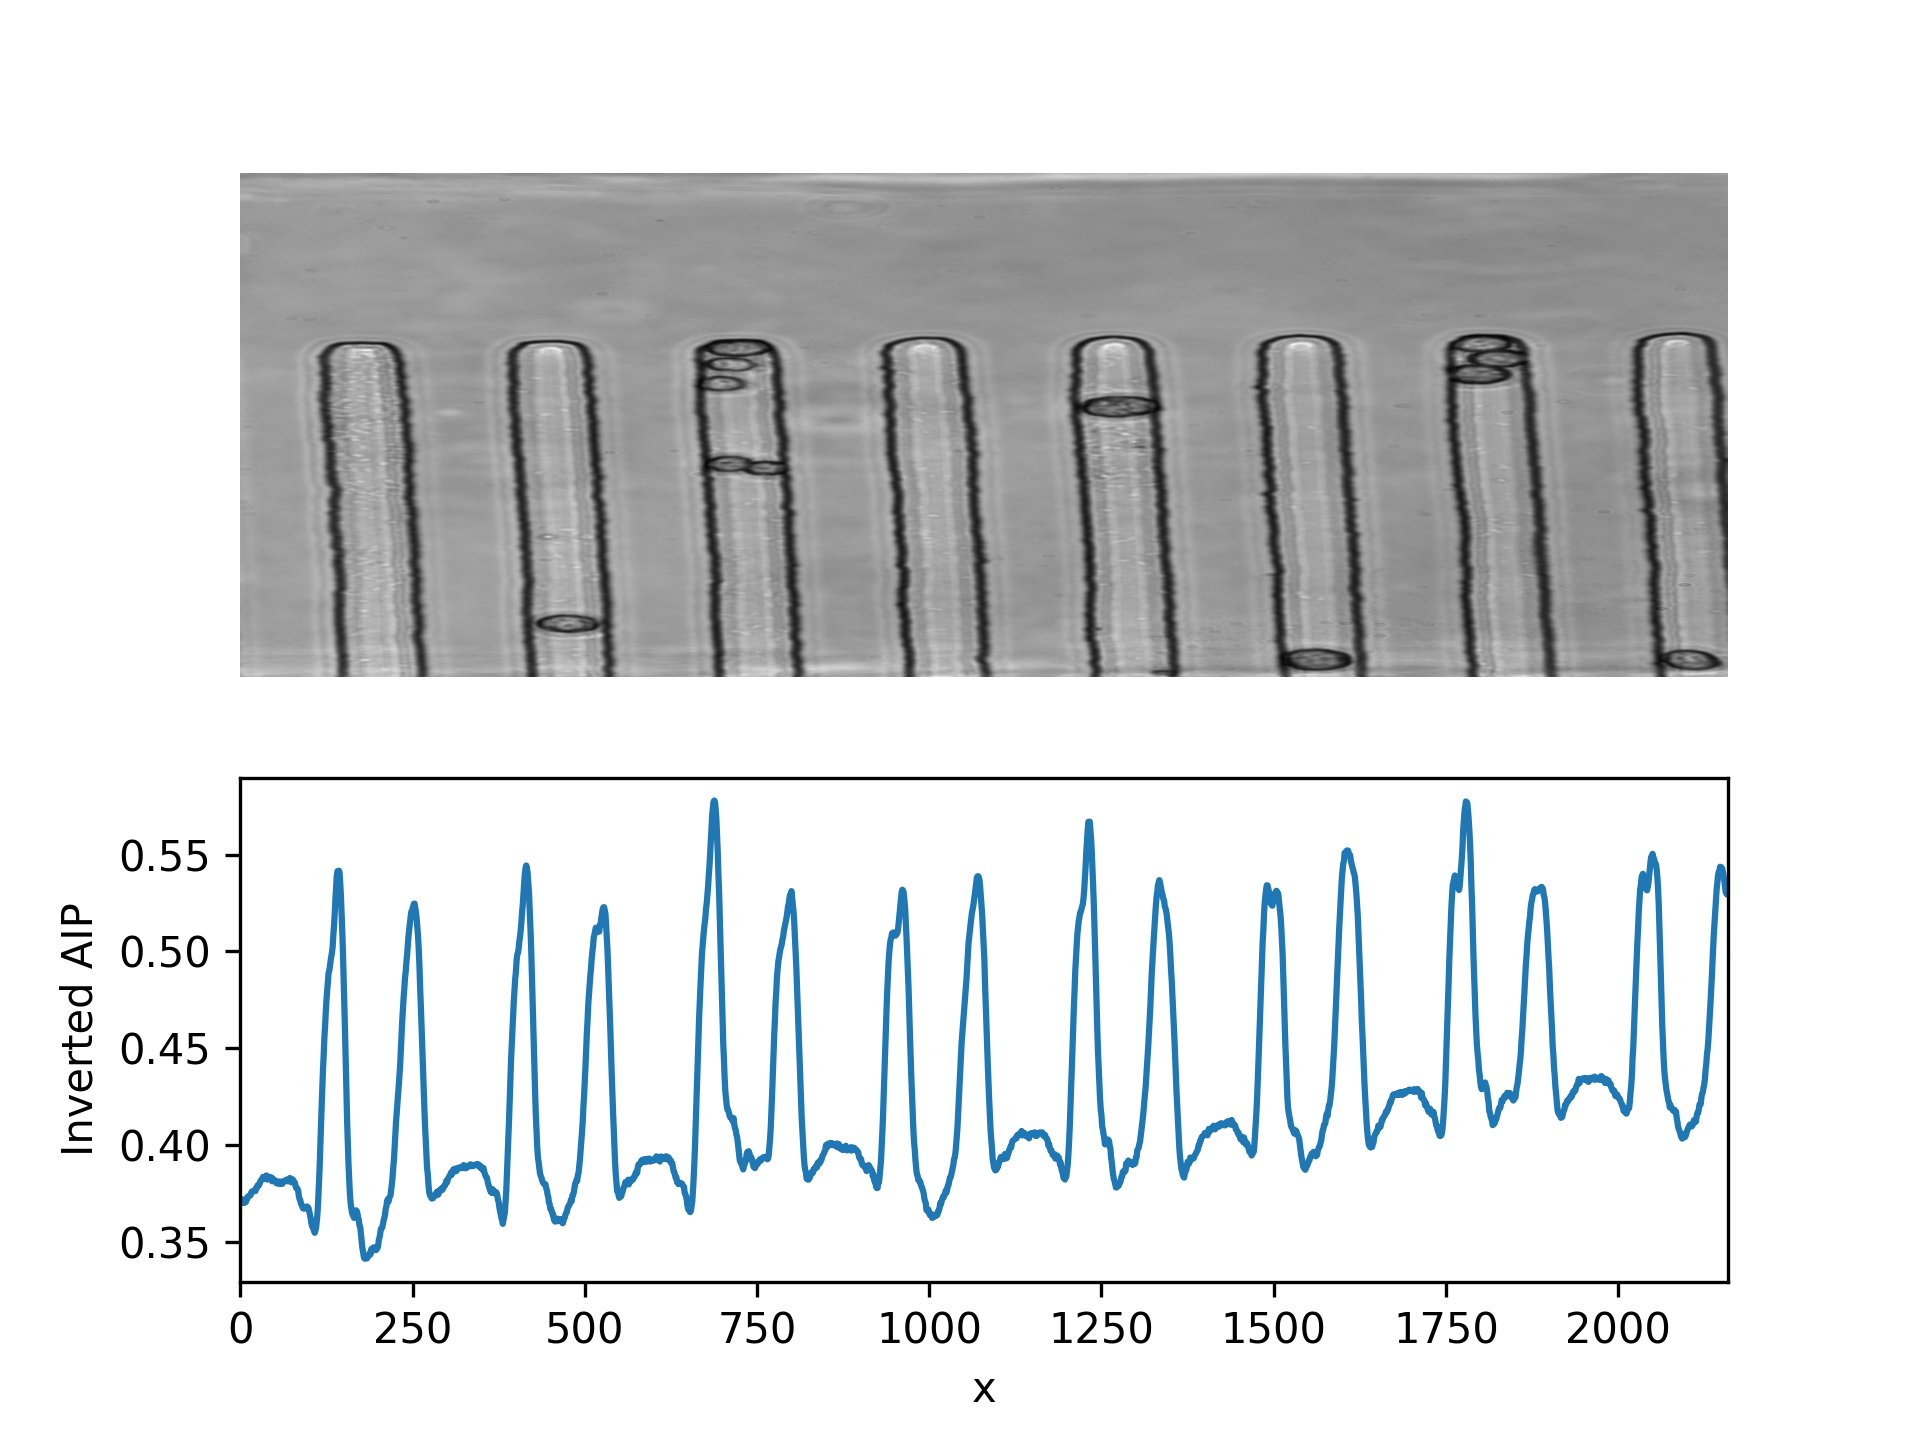

In [20]:
%matplotlib widget
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.imshow(img, cmap="gray", aspect="auto")
ax1.set_axis_off()
ax2.plot(inv_aip)
ax2.set_xlabel("x")
ax2.set_ylabel("Inverted AIP")
plt.show()

In [21]:
min_trap_width = 100
max_trap_width = 150

In [22]:
# fourier analysis
fourier = rfft(inv_aip)
freqs = rfftfreq(inv_aip.size)
magnitudes = np.abs(fourier)
# filter frequency peaks
min_freq = 1 / max_trap_width
max_freq = 1 / min_trap_width
freq_filter = (freqs >= min_freq) & (freqs <= max_freq)
filtered_freqs = freqs[freq_filter]
filtered_magnitudes = magnitudes[freq_filter]
# find highest peak within range --> trap width
max_magnitude_idx = np.argmax(filtered_magnitudes)
trap_width_freq = filtered_freqs[max_magnitude_idx]
trap_width = int(1 / trap_width_freq)
print(trap_width)

135


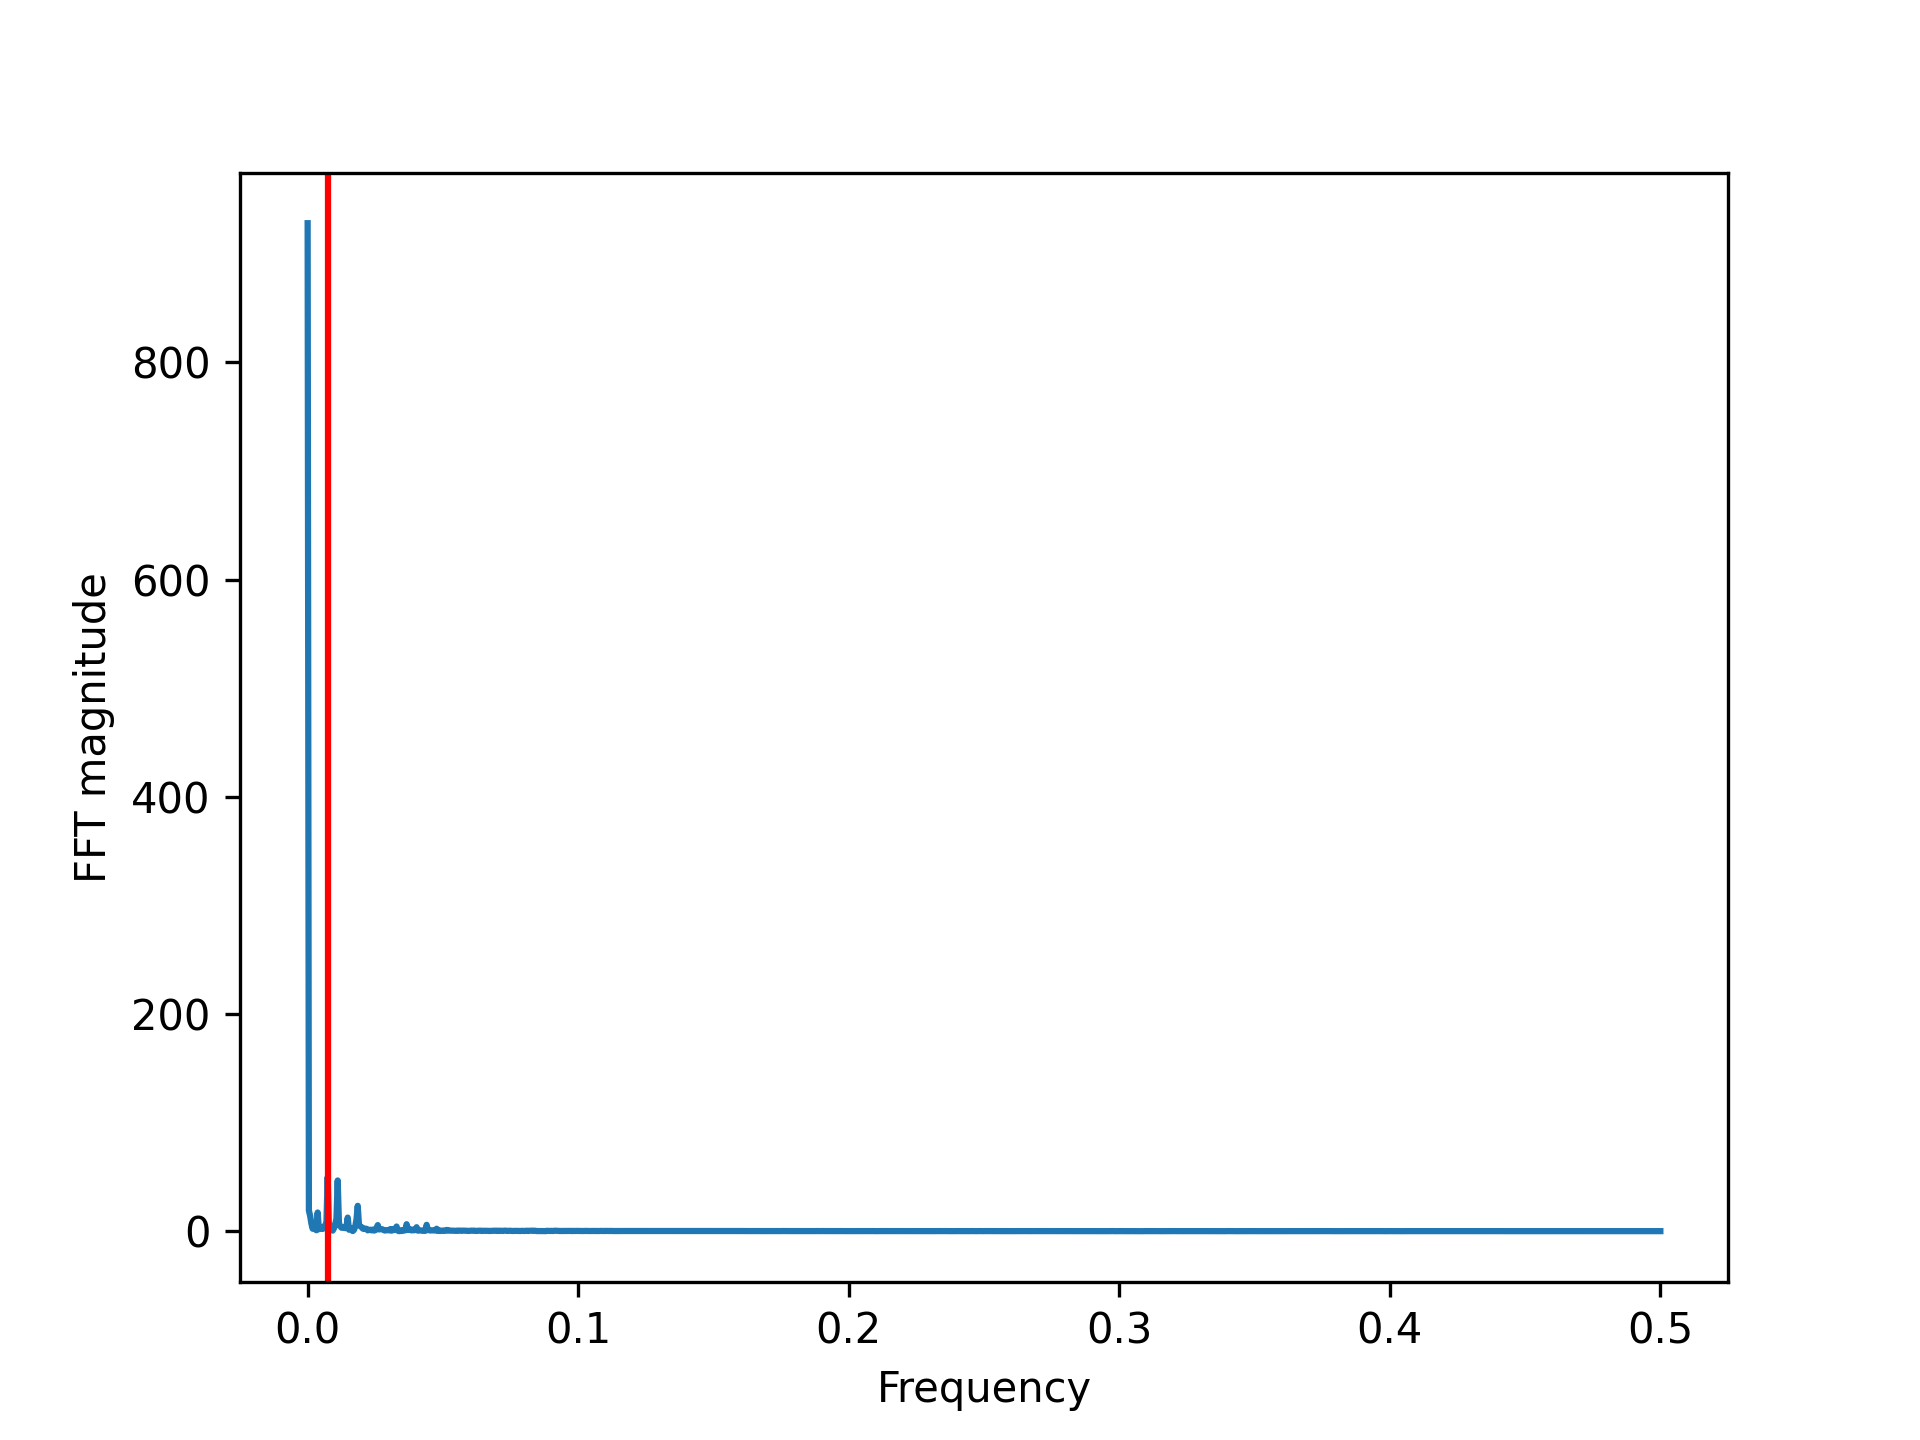

In [23]:
%matplotlib widget
fig, ax = plt.subplots()
ax.plot(freqs, magnitudes)
ax.axvline(trap_width_freq, color="red")
ax.set_xlabel("Frequency")
ax.set_ylabel("FFT magnitude")
plt.show()

In [24]:
# 1D filtering with "trap width-kernel"
ys = inv_aip[:-trap_width] + inv_aip[trap_width:]
xs = 0.5 * trap_width + np.arange(len(ys))
# find peaks --> trap centers
peaks, _ = find_peaks(ys, distance=0.8 * trap_width)
peaks = peaks[::2]  # only if trap spacing = trap width!
trap_centers = xs[peaks]
len(trap_centers)

8

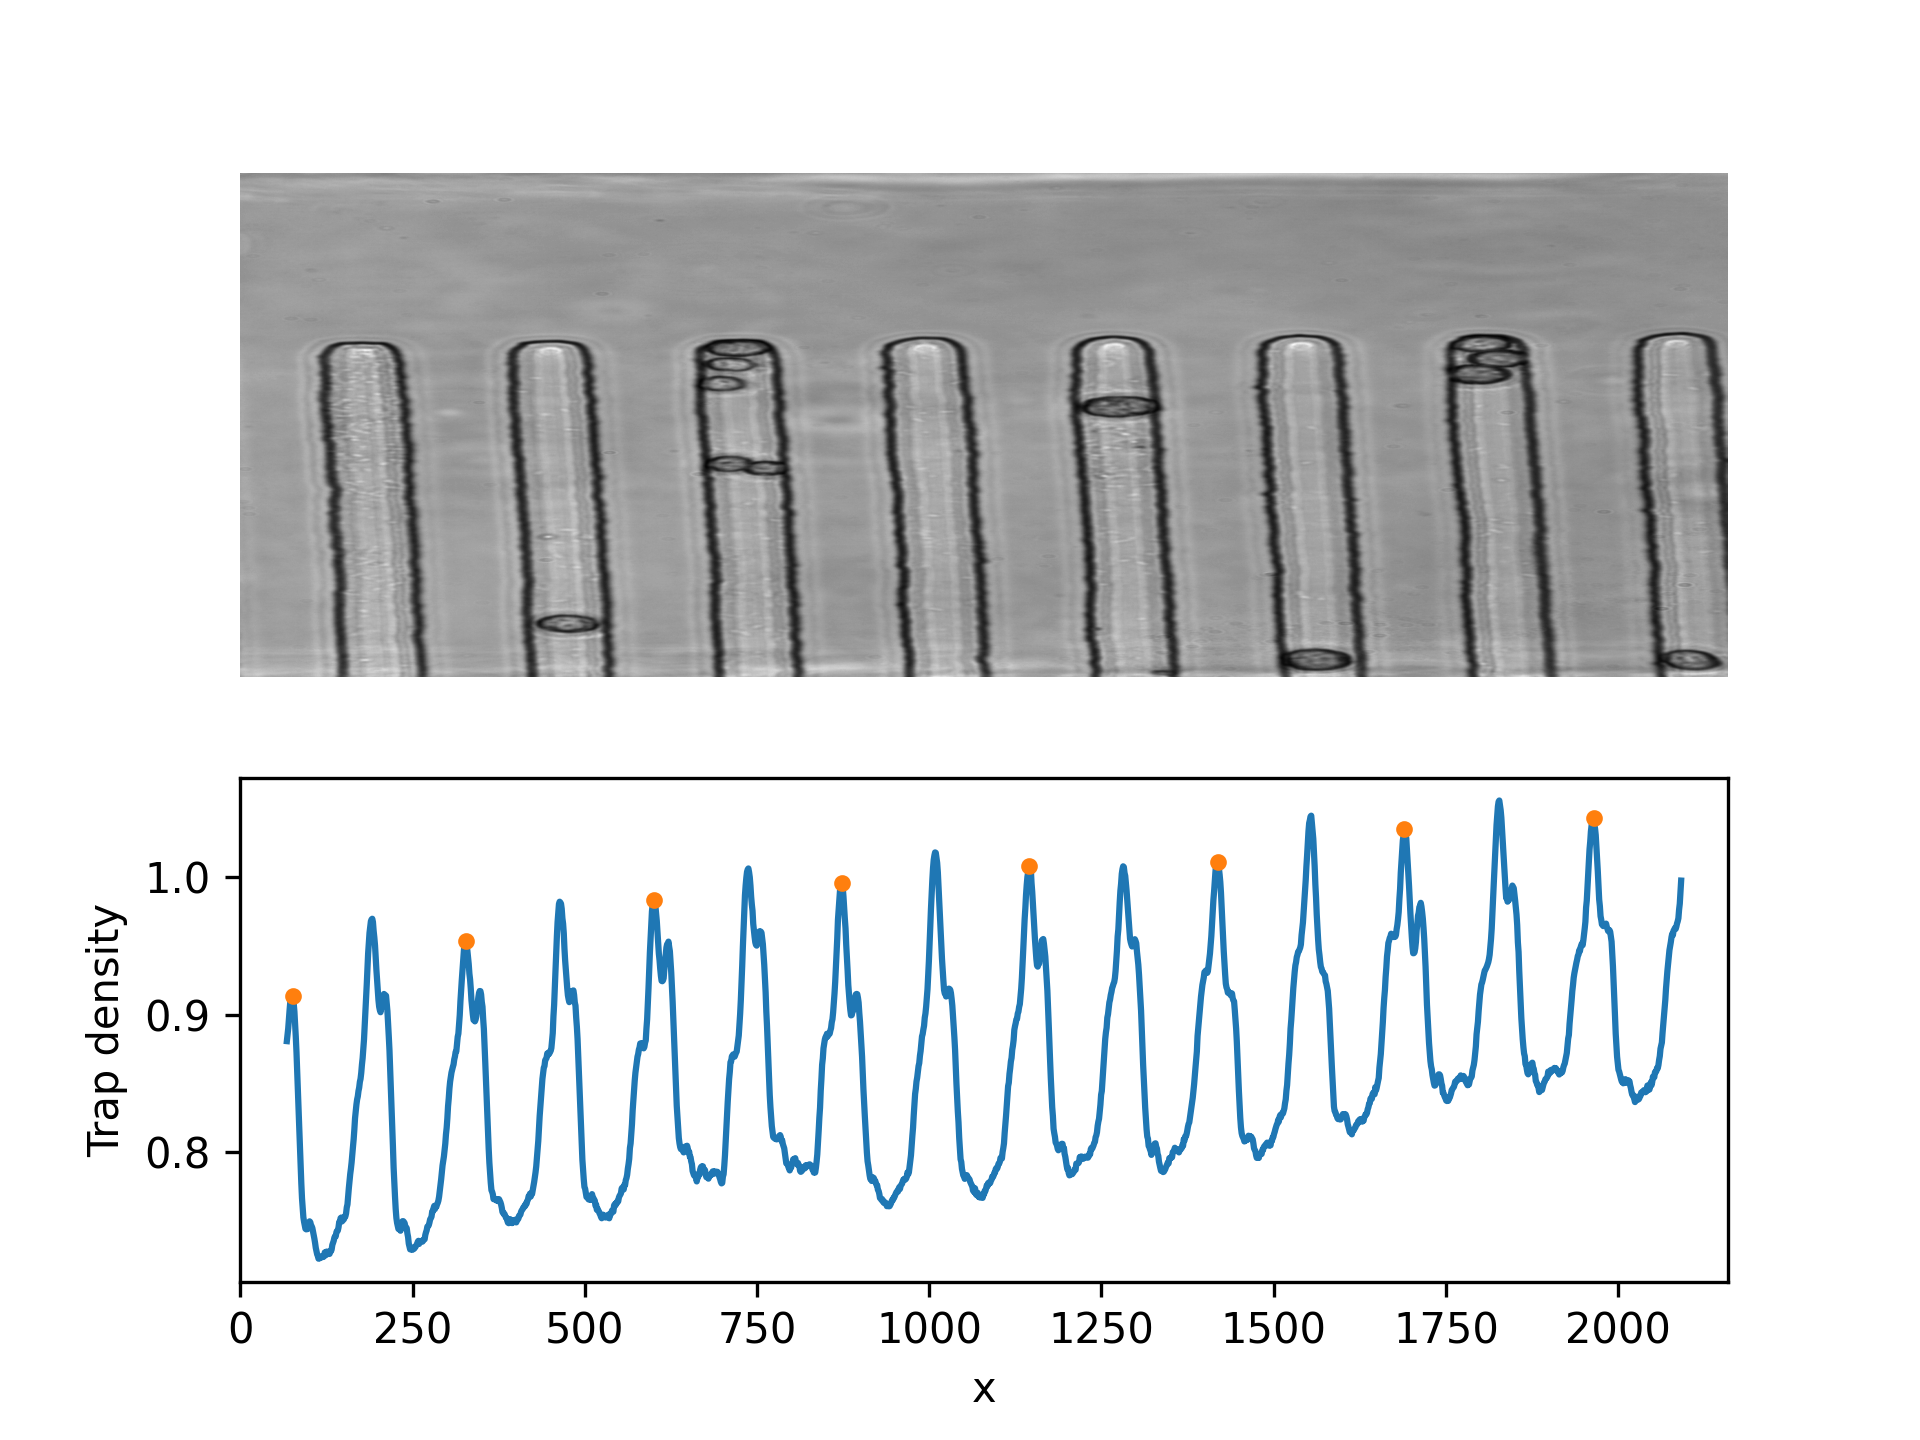

In [25]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.imshow(img, cmap="gray", aspect="auto")
ax1.set_axis_off()
ax2.plot(xs, ys)
ax2.plot(trap_centers, ys[peaks], ".")
ax2.set_xlabel("x")
ax2.set_ylabel("Trap density")
plt.show()

In [26]:
margin = 50

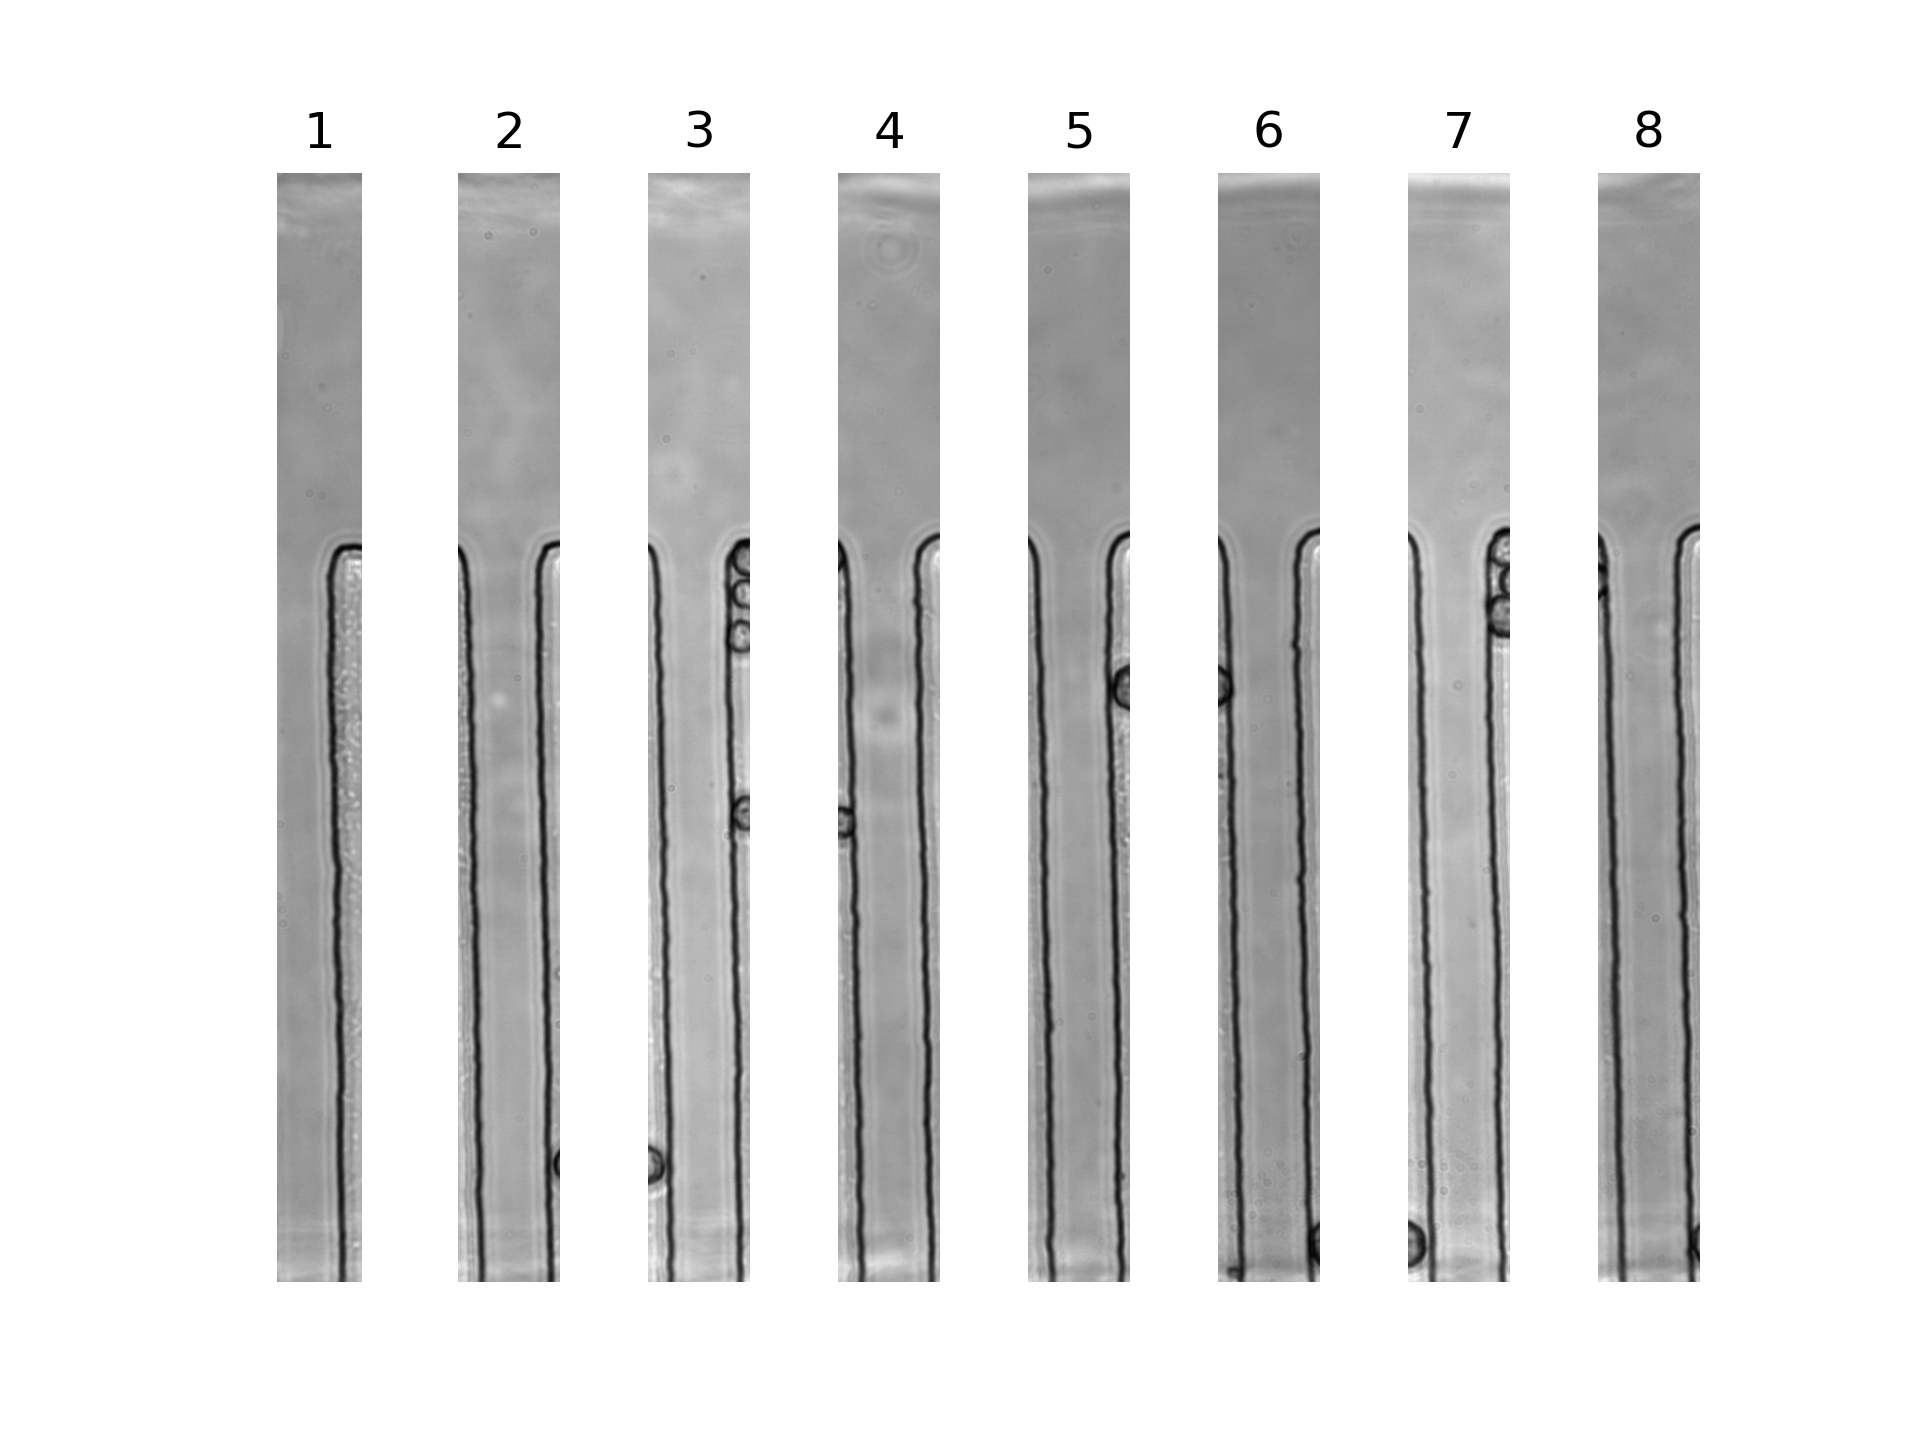

In [27]:
fig, axs = plt.subplots(ncols=len(trap_centers))
for i, (ax, trap_center) in enumerate(zip(axs, trap_centers)):
    trap_start = max(0, int(np.floor(trap_center - 0.5 * trap_width)) - margin)
    trap_end = min(img.shape[-1], int(np.ceil(trap_center + 0.5 * trap_width)) + margin)
    trap_img = img[:, trap_start:trap_end]
    ax.imshow(trap_img, cmap="gray")
    ax.set_axis_off()
    ax.set_title(i + 1)

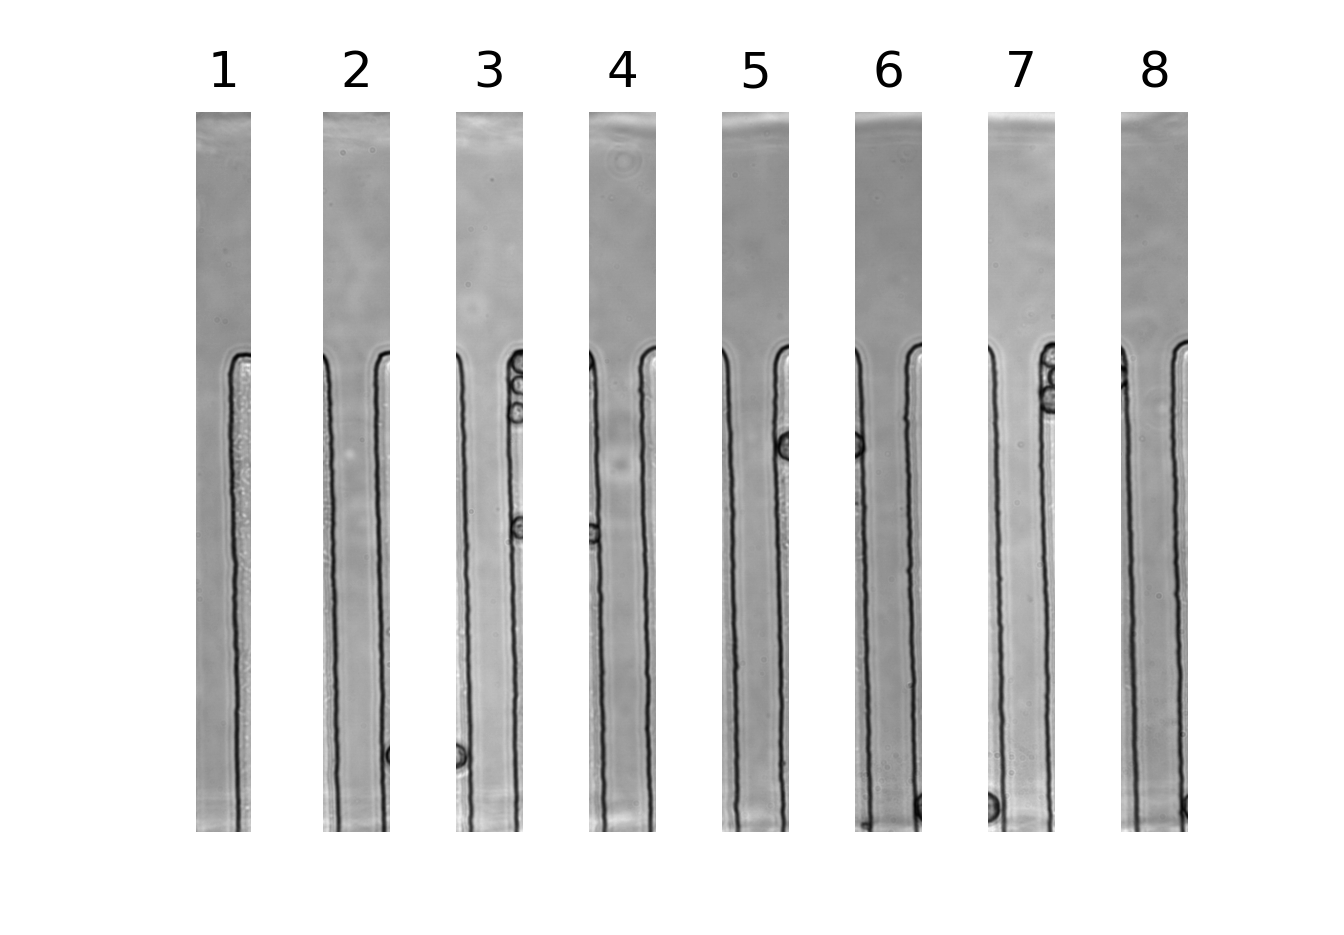

In [28]:
import os

# Assuming you have the following variables defined:
# trap_centers: a list of trap center positions
# trap_width: the width of the traps
# img: the image data

# You may also have margin and other variables defined.

# Specify the output directory where you want to save the images
output_directory = r"C:\Users\micha\Desktop\Master_Project\trap_images_individual"

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Loop through each subplot
for i, (trap_center) in enumerate(trap_centers):
    # Calculate the start and end positions for the trap region
    trap_start = max(0, int(np.floor(trap_center - 0.5 * trap_width)) - margin)
    trap_end = min(img.shape[-1], int(np.ceil(trap_center + 0.5 * trap_width)) + margin)
    
    # Extract the trap region from the image
    trap_img = img[:, trap_start:trap_end]
    
    # Create a folder for each subplot
    folder_path = os.path.join(output_directory, f"subplot_{i + 1}")
    os.makedirs(folder_path, exist_ok=True)
    
    # Save the image inside the folder
    image_path = os.path.join(folder_path, f"trap_image_{i + 1}.png")
    plt.imsave(image_path, trap_img, cmap="gray")
    
# Display the plot
plt.show()


### Fourier ANalysis in pipeline

In [ ]:
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from skimage.util import img_as_float, img_as_ubyte
from scipy.fft import rfft, rfftfreq
from scipy.signal import find_peaks
from tqdm import tqdm
import os
import numpy as np

# Function to process and save trap images
def process_and_save_trap_images(img_file, output_directory, trap_dict):
    # Load greyscale image
    img = imread(img_file, as_gray=True)

    # Inverted AIP
    inv_aip = 1 - img_as_float(img)

    # Fourier analysis
    fourier = rfft(inv_aip)
    freqs = rfftfreq(inv_aip.size)
    magnitudes = np.abs(fourier)

    # Filter frequency peaks
    min_trap_width = 100
    max_trap_width = 150
    min_freq = 1 / max_trap_width
    max_freq = 1 / min_trap_width

    # Find the valid indices for frequency filtering
    valid_indices = (freqs >= min_freq) & (freqs <= max_freq)

    # Apply boolean indexing to frequencies and magnitudes
    filtered_freqs = freqs[valid_indices]
    filtered_magnitudes = magnitudes[valid_indices]

    # Find trap width
    max_magnitude_idx = np.argmax(filtered_magnitudes)
    trap_width_freq = filtered_freqs[max_magnitude_idx]
    trap_width = int(1 / trap_width_freq)

    # 1D filtering with "trap width-kernel"
    ys = inv_aip[:-trap_width] + inv_aip[trap_width:]
    xs = 0.5 * trap_width + np.arange(len(ys))

    # Find peaks --> trap centers
    peaks, _ = find_peaks(ys, distance=0.8 * trap_width)
    peaks = peaks[::2]  # only if trap spacing = trap width!
    trap_centers = xs[peaks]

    # Margin for extracting trap regions
    margin = 50

    # Loop through each trap index
    for i in range(len(trap_centers)):
        trap_index = i + 1  # Trap index is 1-based

        # Calculate the start and end positions for the trap region
        trap_start = max(0, int(np.floor(trap_centers[i] - 0.5 * trap_width)) - margin)
        trap_end = min(img.shape[-1], int(np.ceil(trap_centers[i] + 0.5 * trap_width)) + margin)

        # Extract the trap region from the image
        trap_img = img[:, trap_start:trap_end]

        # Convert to uint8 before saving
        trap_img_uint8 = img_as_ubyte(trap_img)

        # Create a folder for each trap index
        folder_key = f"trap_number_{trap_index}"
        folder_path = trap_dict.get(folder_key, None)

        if folder_path is None:
            folder_path = os.path.join(output_directory, folder_key)
            os.makedirs(folder_path, exist_ok=True)
            trap_dict[folder_key] = folder_path

        # Save the image inside the folder as TIFF
        image_path = os.path.join(folder_path, f"{os.path.splitext(os.path.basename(img_file))[0]}_trap_image_{trap_index}.tiff")
        imsave(image_path, trap_img_uint8, plugin='tifffile')  # Specify the TIFF file format plugin


# Specify the input directory containing the flipped TIFF images
input_directory_flipped_tiffs = subfolder_path_flipped_images

# Specify the output directory where you want to save the trap images
subfolder_name_cropped_traps = "Cropped_traps_directory"
subfolder_path_cropped_traps = os.path.join(result_folder, subfolder_name_cropped_traps)
os.makedirs(subfolder_path_cropped_traps, exist_ok=True)

# Dictionary to keep track of folders for each trap index
trap_folder_dict = {}

# Loop through each file in the input directory
for filename in os.listdir(input_directory_flipped_tiffs):
    if filename.endswith(".tiff") or filename.endswith(".tif"):
        img_file = os.path.join(input_directory_flipped_tiffs, filename)
        process_and_save_trap_images(img_file, subfolder_path_cropped_traps, trap_folder_dict)


# Napari stacking, based on Fourier analysis

In [129]:
import napari
import numpy as np
import matplotlib.pyplot as plt

# Create a Napari viewer
viewer = napari.Viewer()



# Initialize an empty list to store the padded traps
padded_traps = []
trap_starts = []
trap_ends = []

# Find the maximum width among all traps
max_trap_width = 0

# Pad each trap to have the same width
for i, trap_center in enumerate(trap_centers):
    trap_start = max(0, int(np.floor(trap_center - 0.5 * trap_width)) - margin)
    trap_end = min(img.shape[-1], int(np.ceil(trap_center + 0.5 * trap_width)) + margin)
    trap_starts.append(trap_start)
    trap_ends.append(trap_end)
    trap_img = img[:, trap_start:trap_end]

    # Update the maximum width
    max_trap_width = max(max_trap_width, trap_img.shape[1])

    # Add the trap to the list
    padded_traps.append(trap_img)

# Check if there are any traps before calculating max_trap_width
if trap_starts and trap_ends:
    max_trap_width = max(trap_end - trap_start for trap_start, trap_end in zip(trap_starts, trap_ends))

# Pad each trap to the maximum width
for i in range(len(padded_traps)):
    padded_trap = np.pad(padded_traps[i], ((0, 0), (0, max_trap_width - padded_traps[i].shape[1])), mode='constant')
    padded_traps[i] = padded_trap

# Stack the padded traps vertically
stacked_image = np.vstack(padded_traps)

# Add the stacked image as a single layer in Napari
viewer.add_image(stacked_image, colormap='gray', name='Stacked Traps')

# Show the Napari viewer
napari.gui_qt()


C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 235) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(
C:\Users\micha\anaconda3\anaconda_file\envs\napari-env\lib\site-packages\napari\_vispy\layers\image.py:274: UserWarning: data shape (20480, 235) exceeds GL_MAX_TEXTURE_SIZE 16384 in at least one axis and will be downsampled. Rendering is currently in 2D mode.
  warnings.warn(


# Cellpose

In [2]:
import numpy as np
import time, os, sys
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io

#Image path
files = [r"C:\Users\micha\Desktop\Master_Project\original_frame_392_cropped\trap_1.tiff"]

In [21]:
import numpy as np
from cellpose import models, io
from skimage import io as skio
from os.path import join, dirname, basename
import tifffile

files = [r"C:\Users\micha\Desktop\Master_Project\original_frame_392_cropped\trap_1.tiff"]

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto2')

# or if you have different types of channels in each image
channels = [[0, 0]]

# Set custom parameters
custom_params = {
    'diameter': 65.0,                # Set the estimated average cell diameter
    #'resample': True,                # Set whether to resample the image
    'interp': 'lanczos3',             # Choose the interpolation method
    'cellprob_threshold': 1,         # Set the cell probability threshold
    'flow_threshold': 0.4,           # Use the recommended flow threshold (None)
    'min_size': 30                    # Set the minimum size of a segmented object
}


for chan, filename in zip(channels, files):
    img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, channels=chan, **custom_params)

    # Create a binary mask from the cell probability map
    binary_mask = masks[0] > custom_params['cellprob_threshold']

    # Ensure binary_mask is a 2D array
    binary_mask = np.atleast_2d(np.squeeze(binary_mask))

    # Create a 4-channel RGBA image
    rgba_image = np.zeros((binary_mask.shape[0], binary_mask.shape[1], 4), dtype=np.uint8)

    # Set RGB channels to black for non-segmented regions
    rgba_image[..., :3] = 0

    # Set alpha channel to 255 for segmented regions
    rgba_image[..., 3] = 255 * binary_mask.astype(np.uint8)

    # Save the RGBA image as a TIFF file with transparency
    output_path = join(dirname(filename), f'segmented_image_{basename(filename)}.tif')
    tifffile.imsave(output_path, rgba_image)



C:\Users\micha\AppData\Local\Temp\ipykernel_17732\2228556811.py:65: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(output_path, rgba_image)


In [19]:
import napari
from skimage import io as skio

# Load the input image and binary mask
img = io.imread(files[0])
binary_mask = skio.imread(output_path)

# Ensure binary_mask is 2D
binary_mask = np.squeeze(binary_mask)

# Create a binary mask where segmented regions are 1 and non-segmented regions are 0
binary_mask = (binary_mask > 0).astype(float)

# Create a napari viewer
viewer = napari.view_image(img, name='Input Image')
viewer.add_image(binary_mask, name='Binary Mask', opacity=0.0, colormap='gray')  # Set opacity to 0 for binary mask

# Create a layer with white or black color for non-segmented regions
non_segmented_color = [1, 1, 1]  # Change to [0, 0, 0] for black
non_segmented_layer = np.ones_like(binary_mask[..., None]) * non_segmented_color
viewer.add_image(non_segmented_layer, name='Non-Segmented Regions', opacity=1.0)

# Run the Napari viewer
napari.run()


ValueError: shape mismatch: value array of shape (3,) could not be broadcast to indexing result of shape (2322,4)

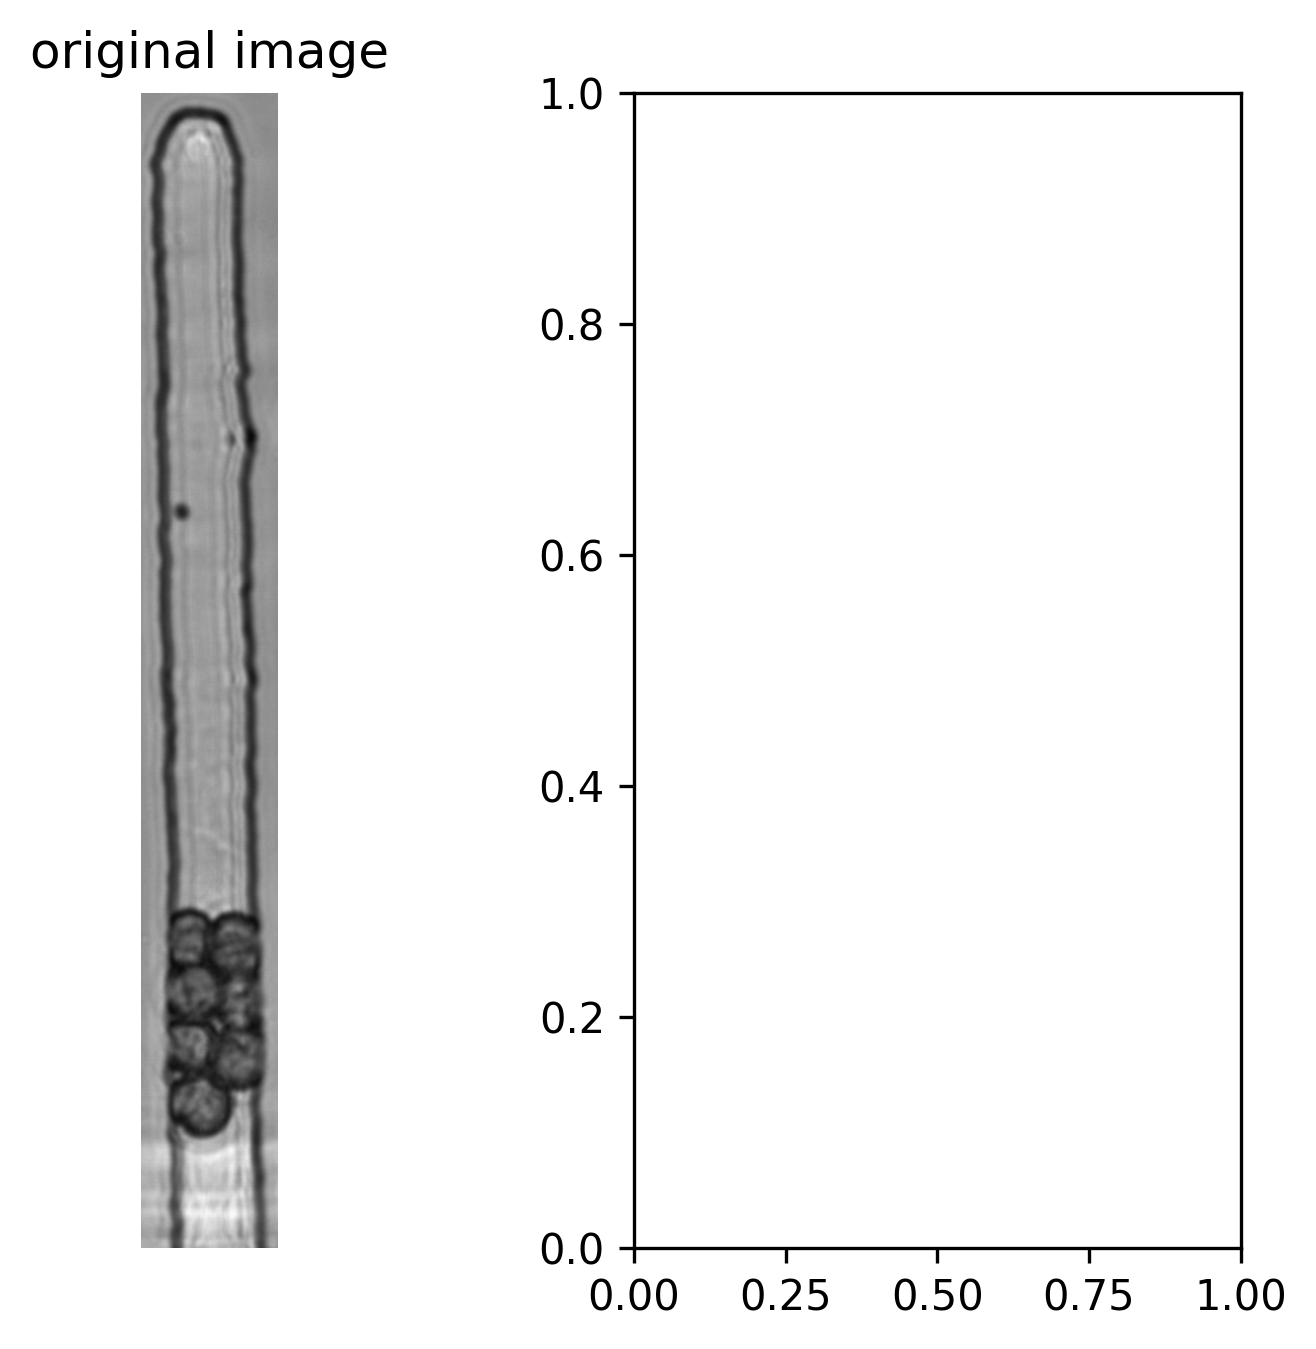

In [17]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()

# Experimenation with cell pose on mutiple iamges


Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_100_trap_image_4.png
Input image shape: (2560, 235)


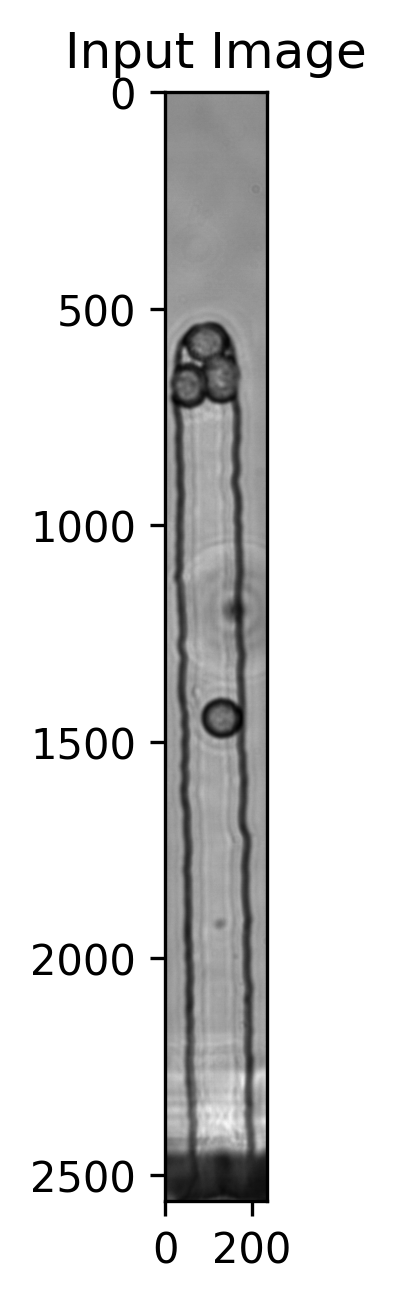

Image data type after conversion: uint8
Shape of masks: (2560, 235)
Saved results to: C:\Users\micha\Desktop\Cellpose_test\segmentation_mask_original_frame_100_trap_image_4.png

Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_101_trap_image_4.png
Input image shape: (2560, 235)


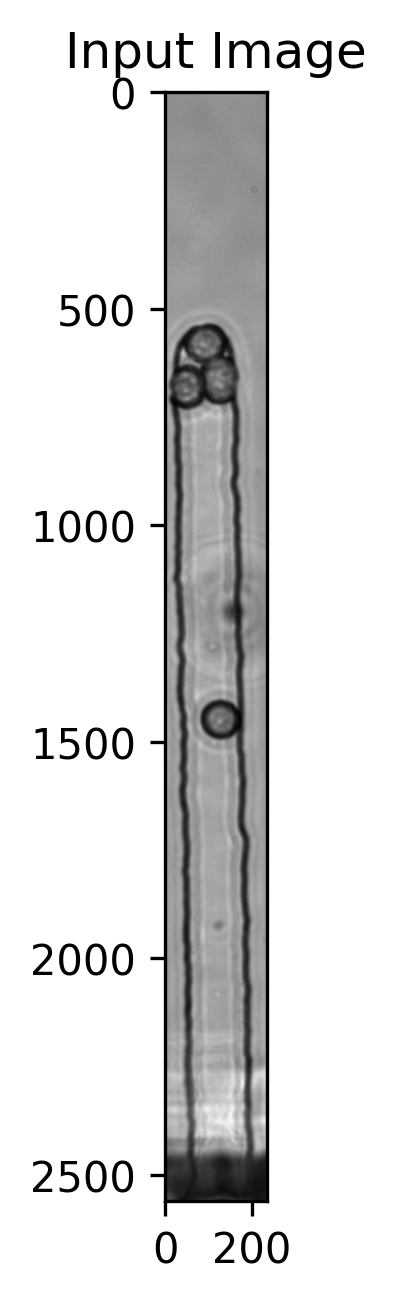

Image data type after conversion: uint8
Shape of masks: (2560, 235)
Saved results to: C:\Users\micha\Desktop\Cellpose_test\segmentation_mask_original_frame_101_trap_image_4.png

Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_102_trap_image_4.png
Input image shape: (2560, 235)


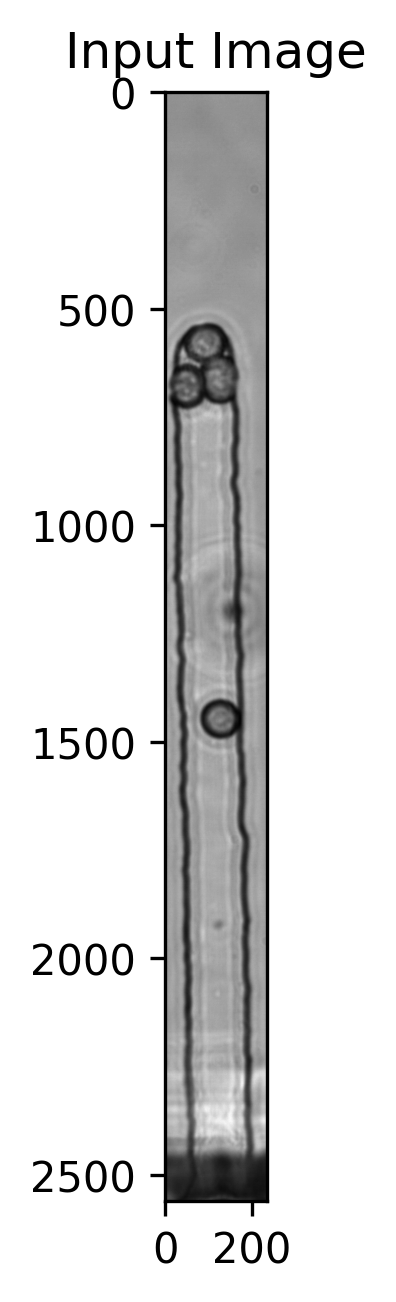

Image data type after conversion: uint8
Shape of masks: (2560, 235)
Saved results to: C:\Users\micha\Desktop\Cellpose_test\segmentation_mask_original_frame_102_trap_image_4.png

Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_103_trap_image_4.png
Input image shape: (2560, 235)


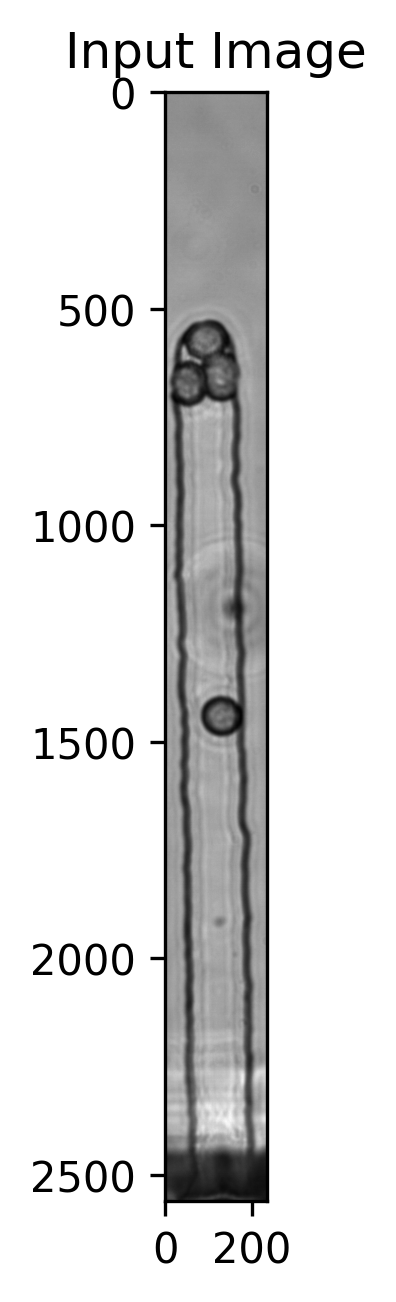

Image data type after conversion: uint8
Shape of masks: (2560, 235)
Saved results to: C:\Users\micha\Desktop\Cellpose_test\segmentation_mask_original_frame_103_trap_image_4.png

Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_104_trap_image_4.png
Input image shape: (2560, 235)


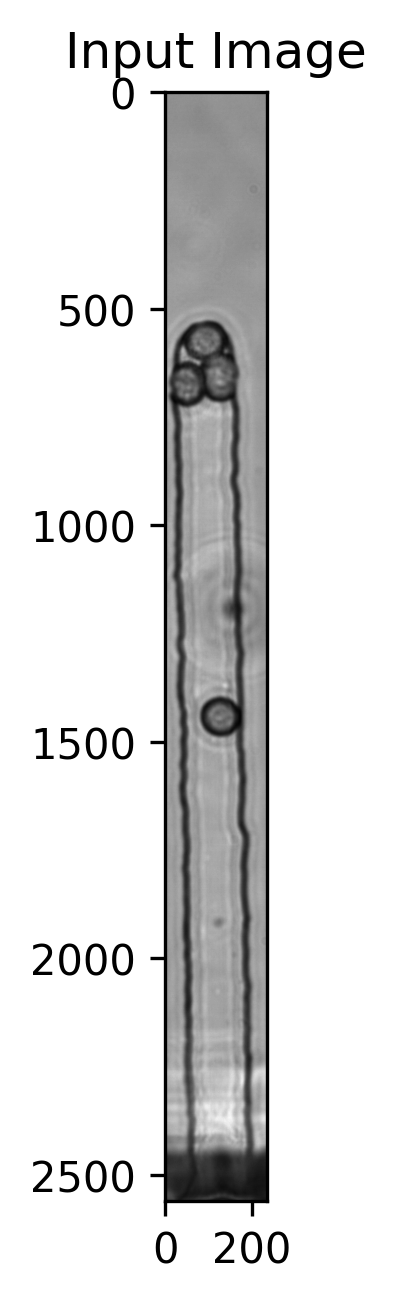

Image data type after conversion: uint8
Shape of masks: (2560, 235)
Saved results to: C:\Users\micha\Desktop\Cellpose_test\segmentation_mask_original_frame_104_trap_image_4.png

Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_105_trap_image_4.png
Input image shape: (2560, 235)


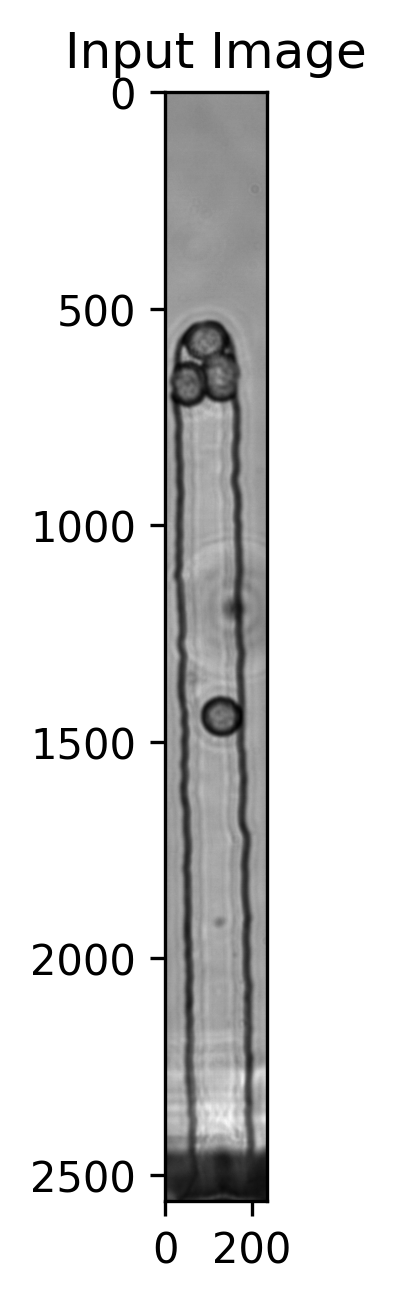

Image data type after conversion: uint8
Shape of masks: (2560, 235)
Saved results to: C:\Users\micha\Desktop\Cellpose_test\segmentation_mask_original_frame_105_trap_image_4.png

Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_106_trap_image_4.png
Input image shape: (2560, 235)


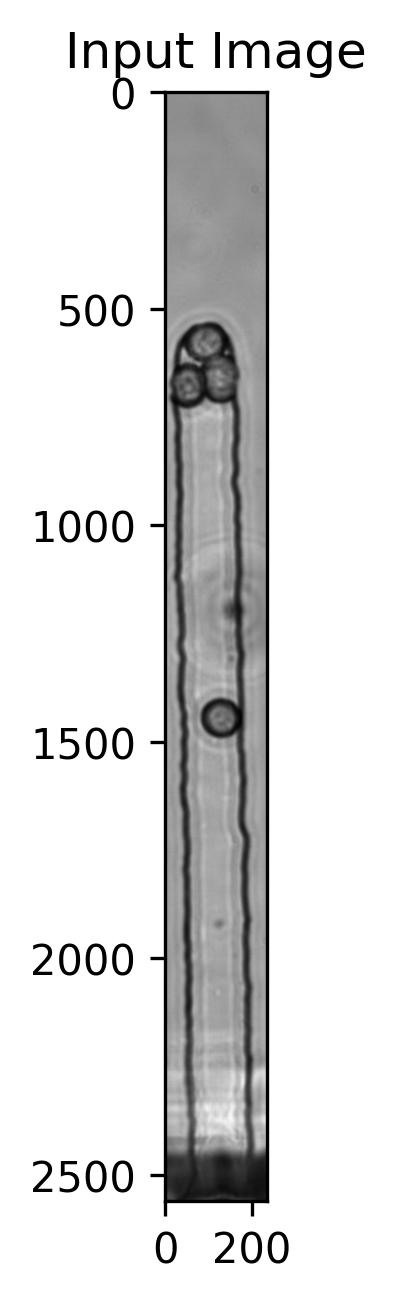

Image data type after conversion: uint8
Shape of masks: (2560, 235)
Saved results to: C:\Users\micha\Desktop\Cellpose_test\segmentation_mask_original_frame_106_trap_image_4.png

Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_107_trap_image_4.png
Input image shape: (2560, 235)


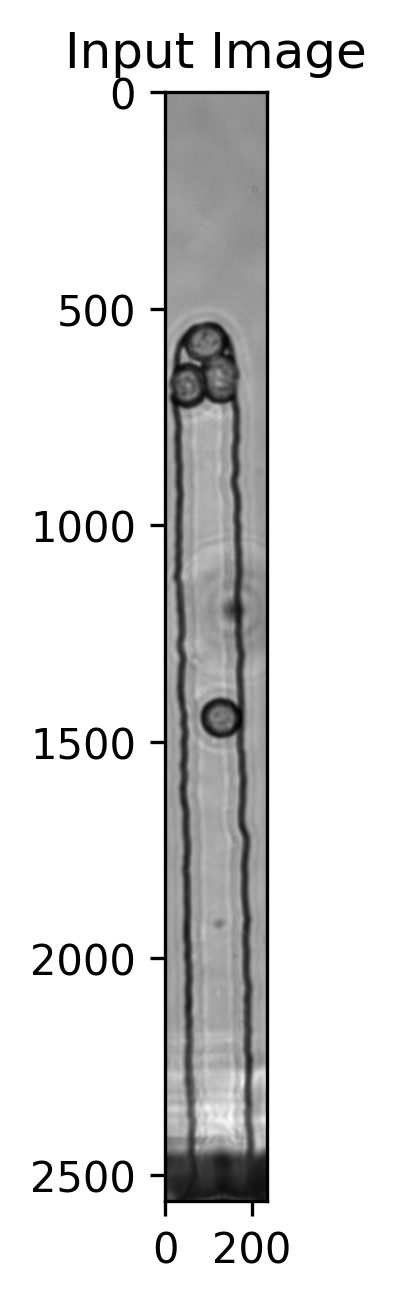

Image data type after conversion: uint8
Shape of masks: (2560, 235)
Saved results to: C:\Users\micha\Desktop\Cellpose_test\segmentation_mask_original_frame_107_trap_image_4.png

Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_108_trap_image_4.png
Input image shape: (2560, 235)


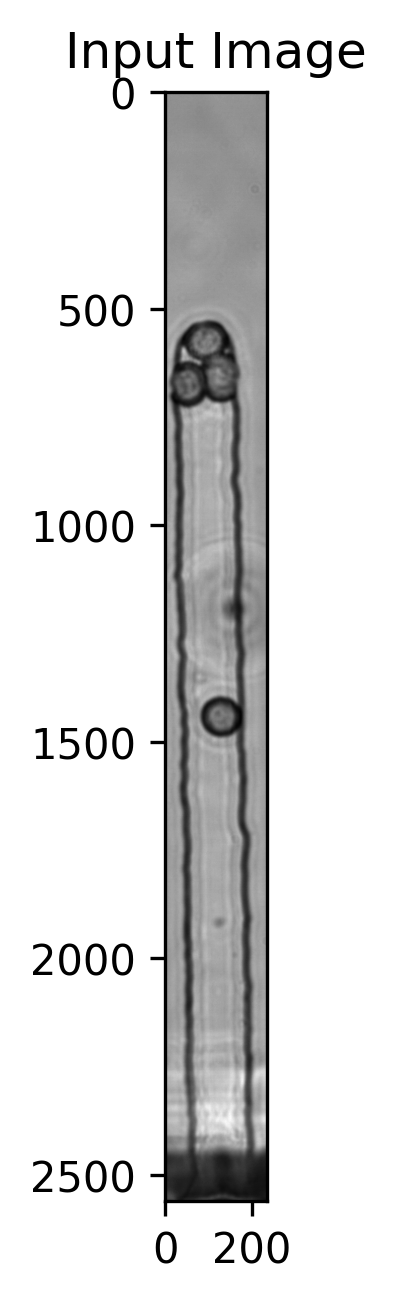

Image data type after conversion: uint8
Shape of masks: (2560, 235)
Saved results to: C:\Users\micha\Desktop\Cellpose_test\segmentation_mask_original_frame_108_trap_image_4.png

Processing image: C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4\original_frame_109_trap_image_4.png
Input image shape: (2560, 235)


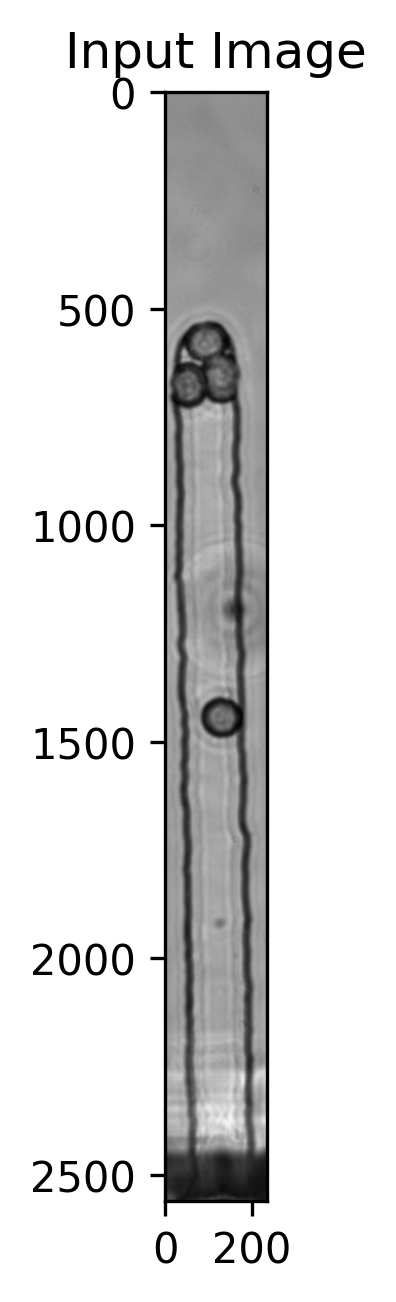

Image data type after conversion: uint8
Shape of masks: (2560, 235)


KeyboardInterrupt: 

In [37]:
import os
from cellpose import models, io
from skimage import img_as_ubyte
import matplotlib.pyplot as plt

# Image and output folders
input_folder = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4"
output_folder = r"C:\Users\micha\Desktop\Cellpose_test"

# List all PNG files in the input folder
files = [os.path.join(input_folder, filename) for filename in os.listdir(input_folder) if filename.lower().endswith('.png')]

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# DEFINE CELLPOSE MODEL
model = models.Cellpose(gpu=False, model_type='cyto2')

# Define custom parameters 
custom_params = {
    'diameter': 65.0,                # Set the estimated average cell diameter
    'interp': 'lanczos3',             # Choose the interpolation method
    'cellprob_threshold': 1,         # Set the cell probability threshold
    'flow_threshold': 0.4,           # Use the recommended flow threshold (None)
    'min_size': 30                    # Set the minimum size of a segmented object
}

# Define channels for all images
channels = [[0, 0]]

# Iterate through each image
for filename in files:
    print(f"\nProcessing image: {filename}")

    # Step 1: Load and visualize the input image
    img = io.imread(filename)
    print("Input image shape:", img.shape)

    # Visualize the input image
    plt.figure()
    plt.imshow(img, cmap='gray')
    plt.title("Input Image")
    plt.show()

    # Convert image to uint8
    img_uint8 = img_as_ubyte(img)

    # Step 2: Print the image data type after conversion
    print("Image data type after conversion:", img_uint8.dtype)

    masks, flows, styles, diams = model.eval(img_uint8, channels=channels, **custom_params)

    # Step 5: Print the shape of masks
    print("Shape of masks:", masks.shape)

    # Save results as PNG
    output_filename = os.path.join(output_folder, f"segmentation_mask_{os.path.basename(filename)}")
    io.save_to_png(img_uint8, masks, flows, output_filename)

    print(f"Saved results to: {output_filename}")


#save masks to dictionary 




In [27]:
import os
from cellpose import models, io
from skimage import img_as_ubyte
from os.path import join, basename, splitext

# Image and output folders
input_folder = "C:/Users/micha/Desktop/Master_Project/original_frame_392_cropped/"
output_folder = input_folder

# List all TIFF files in the input folder
files = [os.path.join(input_folder, filename) for filename in os.listdir(input_folder) if filename.lower().endswith('.tif')]

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# DEFINE CELLPOSE MODEL
model = models.Cellpose(gpu=False, model_type='cyto2')

# Define custom parameters 
custom_params = {
    'diameter': 65.0,                # Set the estimated average cell diameter
    'interp': 'lanczos3',             # Choose the interpolation method
    'cellprob_threshold': 0.1,         # Set the cell probability threshold
    'flow_threshold': 0.4,           # Use the recommended flow threshold (None)
    'min_size': 30                    # Set the minimum size of a segmented object
}

# Define channels for all images
channels = [[0, 0]]

for chan, filename in zip(channels, files):
    img = io.imread(filename)
    img_uint8 = img_as_ubyte(img)  # Convert to uint8 if needed

    masks, flows, styles, diams = model.eval(img_uint8, channels=channels, **custom_params)

    # Save label images as TIFF
    label_output_path = join(output_folder, f'label_image_{splitext(basename(filename))[0]}.tif')
    io.masks_flows_to_seg(img_uint8, masks, flows, diams, label_output_path, chan)

    # Save cell probability maps as TIFF
    prob_output_path = join(output_folder, f'cell_prob_map_{splitext(basename(filename))[0]}.tif')
    io.save_to_png(img_uint8, masks, flows, prob_output_path)


In [ ]:
image_paths_cp = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4"

len(image_paths_cp)

from cellpose import models, io
model = models.Cellpose(gpu=True, model_type='cyto2')
channels= [[0,0]]
mask_dict = {}
len(image_paths_cp)
for chan, filename in tqdm(zip (channels, files_cellpose), total = len(files_cellpose)):
img = io.imread(filename)
masks, flows, styles, diams = model.eval(img, diameter=150, channels=chan, flow_threshold-0.8, cellprob_threshold-0.00001) mask_dict[filename] = masks

In [50]:
print(masks[2000])
#print unique integers, how many objects are found 
np.unique(masks.flatten())


[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18], dtype=uint16)

In [ ]:
single_cell_mask = np.where(mask == cell_id, 1, 0)  # Create a binary mask for the current cell
            single_cell_mask = single_cellmask.copy().astype(np.uint8)
            contours,  = cv2.findContours(single_cell_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            crop_mask = np.zeros_like(single_cell_mask).astype(np.uint8)
            cv2.drawContours(crop_mask, contours, -1, 255, thickness=cv2.FILLED)



In [56]:
import os
from cellpose import models, io
from skimage import img_as_ubyte
from skimage.color import gray2rgb
from skimage.draw import polygon
from tqdm import tqdm

# Path to the folder containing images
image_paths_cp = r"C:\Users\micha\Desktop\MM_data_Pipeline_results_all\MM_pipeline_results_tiff_file_converted\Cropped_traps_directory\trap_number_4"

# List all PNG files in the input folder
files_cellpose = [os.path.join(image_paths_cp, filename) for filename in os.listdir(image_paths_cp) if filename.lower().endswith('.png')]

# Output directory for segmented images
output_directory = r"C:\Users\micha\Desktop\Cellpose_test"

# Initialize the Cellpose model
model = models.Cellpose(gpu=True, model_type='cyto2')

# Specify channels for processing
channels = [[0, 0]]

# Dictionary to store masks for each image
mask_dict = {}

# Loop through each image in files_cellpose
for filename in tqdm(files_cellpose, total=len(files_cellpose)):
    # Load the image
    img = io.imread(filename)

    # Perform Cellpose segmentation
    masks, _, _, _ = model.eval(
        img,
        diameter=65,
        channels=channels,
        flow_threshold=0.8,
        cellprob_threshold=0.00001,
    )

    # Save masks in the dictionary
    mask_dict[filename] = masks

# Now, mask_dict contains masks for each image in files_cellpose

# Apply masks to each image
for filename, masks in tqdm(mask_dict.items(), total=len(mask_dict)):
    # Load the image
    img = io.imread(filename)

    # Extract trap number from the filename
    trap_number = int(filename.split("trap_number_")[1].split("\\")[0])

    # Create an empty mask with the same shape as the original image
    segmentation_mask = np.zeros_like(img[:, :, 0])
    for channel in range(img.shape[2]):
        segmentation_mask += img[:, :, channel]
    segmentation_mask = np.where(segmentation_mask > 0, 1, 0)


    # Iterate over each mask and draw it on the empty mask
    for mask in masks:
        rr, cc = polygon(mask[:, 0], mask[:, 1])
        segmentation_mask[rr, cc] = 1  # Assign a value (e.g., 1) inside the mask

    # Apply the segmentation mask to the original image
    segmented_image = img_as_ubyte(gray2rgb(img))
    segmented_image[:, :, 0] = segmented_image[:, :, 0] * segmentation_mask
    segmented_image[:, :, 1] = segmented_image[:, :, 1] * segmentation_mask
    segmented_image[:, :, 2] = segmented_image[:, :, 2] * segmentation_mask

    # Save or visualize the segmented image
    output_filename = os.path.join(output_directory, f"segmented_trap_{trap_number}_{os.path.basename(filename)}")
    io.imsave(output_filename, segmented_image)


  0%|          | 0/392 [00:00<?, ?it/s]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
model = models.Cellpose(gpu=False, model_type='cyto2')

# define CHANNELS to run segmentation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[0,0]]

# Set custom parameters
custom_params = {
    'diameter': 65.0,                # Set the estimated average cell diameter
    #'resample': True,                # Set whether to resample the image
    'interp': 'lanczos3',             # Choose the interpolation method
    'cellprob_threshold': 1 ,      # Set the cell probability threshold
    'flow_threshold': 0.4,           # Use the recommended flow threshold (None)
    'min_size': 30                    # Set the minimum size of a segmented object
}


# or in a loop
for chan, filename in zip(channels, files):
    img = io.imread(filename)
    
    # Fine-tune the model by providing custom parameters
    masks, flows, styles, diams = model.eval(img, channels=chan, **custom_params)

    # Save masks as TIFF
    for i, mask in enumerate(masks):
        mask_output_path = f'mask_{i + 1}.tiff'
        imageio.imwrite(mask_output_path, mask.astype('uint8') * 255)  # Assuming masks are binary, converting to uint8

    # Save results as PNG (optional)
    io.save_to_png(img, masks, flows, filename)
